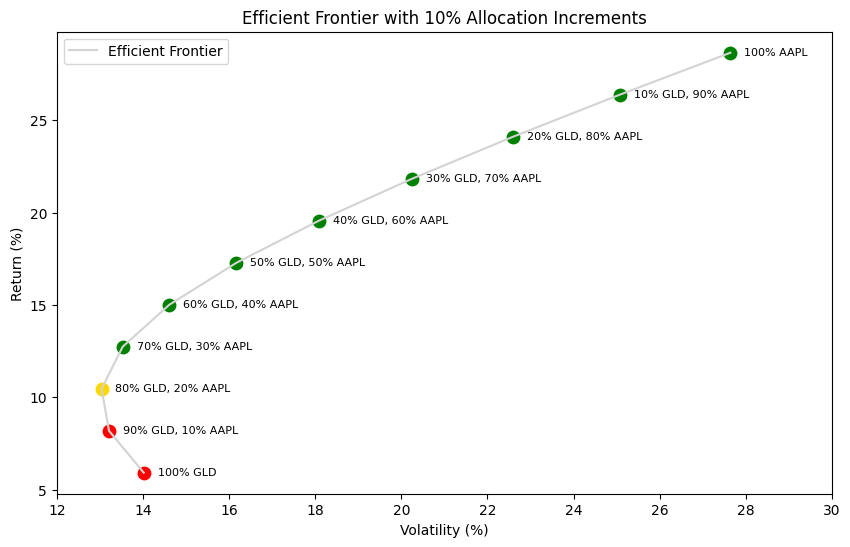

    AAPL Weight (%)  GLD Weight (%)  Return (%)  Volatility (%)  Sharpe Ratio
0             100.0             0.0       28.65           27.64        0.9642
1              90.0            10.0       26.38           25.07        0.9724
2              80.0            20.0       24.10           22.60        0.9783
3              70.0            30.0       21.83           20.25        0.9793
4              60.0            40.0       19.56           18.08        0.9708
5              50.0            50.0       17.28           16.17        0.9450
6              40.0            60.0       15.01           14.61        0.8902
7              30.0            70.0       12.73           13.53        0.7934
8              20.0            80.0       10.46           13.04        0.6487
9              10.0            90.0        8.18           13.21        0.4681
10              0.0           100.0        5.91           14.02        0.2789


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(file_path):
    df = pd.read_csv(file_path, delimiter=';')
    df.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'High', 
                        'Najnizszy': 'Low', 'Zamkniecie': 'Close'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df.sort_values('Date', inplace=True)
    return df

# Load data for AAPL and GLD (gold asset)
aapl = load_data("aapl_us_m_2014-2024.csv")
gld = load_data("xauusd_m_2014-2024.csv")  # Assuming the gold data is in this file

# Select the last 10 years of data
start_date = aapl['Date'].max() - pd.DateOffset(years=10)
aapl_10y = aapl[aapl['Date'] >= start_date]
gld_10y = gld[gld['Date'] >= start_date]

# Compute monthly returns
returns_aapl = aapl_10y.set_index('Date')['Close'].pct_change()
returns_gld = gld_10y.set_index('Date')['Close'].pct_change()
returns = pd.concat([returns_aapl, returns_gld], axis=1).dropna()
returns.columns = ['AAPL', 'GLD']

# Annualize the mean returns and covariance matrix (assuming 12 months per year)
mean_returns = returns.mean() * 12
cov_matrix = returns.cov() * 12

def portfolio_performance(weights, mean_returns, cov_matrix):
    """Calculate expected return and volatility for a given portfolio."""
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, vol

# Calculate the efficient frontier using 10% increments.
# Here, weight for GLD is w and weight for AAPL is (1 - w).
weights_range = np.linspace(0, 1, 11)
efficient_frontier = []
for w in weights_range:
    # Weight allocation: [AAPL, GLD]
    weights = np.array([1 - w, w])
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe = (ret - 0.02) / vol  # using a risk-free rate of 2%
    efficient_frontier.append([ (1 - w) * 100,  # AAPL weight (%)
                                w * 100,        # GLD weight (%)
                                ret * 100,      # Expected return (%)
                                vol * 100,      # Volatility (%)
                                sharpe])

efficient_frontier_df = pd.DataFrame(efficient_frontier, 
                                     columns=['AAPL Weight (%)', 'GLD Weight (%)', 'Return (%)', 'Volatility (%)', 'Sharpe Ratio'])

# Plot the efficient frontier line in light gray.
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(efficient_frontier_df['Volatility (%)'], efficient_frontier_df['Return (%)'], 
        color='lightgray', linestyle='-', label='Efficient Frontier')

# Plot and annotate each point with specific colors.
for idx, row in efficient_frontier_df.iterrows():
    # Choose the color based on the point index:
    # First two dots: red; third: yellow; rest: green.
    if idx > 8:
        point_color = 'red'
    elif idx == 8:
        point_color = 'gold'
    else:
        point_color = 'green'
        
    # Plot the dot with the desired color.
    ax.scatter(row['Volatility (%)'], row['Return (%)'], marker='o', color=point_color, s=80)
    
    # Round the values to avoid floating point issues.
    aapl_pct = int(round(row['AAPL Weight (%)']))
    gld_pct = int(round(row['GLD Weight (%)']))
    
    # Create label: if one of the tickers is 100%, show only that ticker.
    if gld_pct == 100:
        label = "100% GLD"
    elif aapl_pct == 100:
        label = "100% AAPL"
    else:
        label = f"{gld_pct}% GLD, {aapl_pct}% AAPL"
        
    # Annotate the dot with the label.
    ax.annotate(label, 
                (row['Volatility (%)'], row['Return (%)']),
                textcoords="offset points", xytext=(10, 0),
                ha='left', va='center', fontsize=8)

ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Return (%)')
ax.set_title('Efficient Frontier with 10% Allocation Increments')
ax.legend()

# Expand the x-axis (volatility) range (adjust as needed)
ax.set_xlim(12, 30)

plt.show()

# Optionally, print the efficient frontier table
# Print the efficient frontier table with specific formatting
formatted_df = efficient_frontier_df.copy()
formatted_df[['AAPL Weight (%)', 'GLD Weight (%)', 'Return (%)', 'Volatility (%)']] = formatted_df[['AAPL Weight (%)', 'GLD Weight (%)', 'Return (%)', 'Volatility (%)']].round(2)
formatted_df['Sharpe Ratio'] = formatted_df['Sharpe Ratio'].round(4)

print(formatted_df)